In [ ]:
!pip install mplfinance
import datetime
import requests
import matplotlib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import numpy as np
from sklearn.linear_model import LinearRegression
import os
from pathlib import Path


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 526.5 kB/s eta 0:00:00


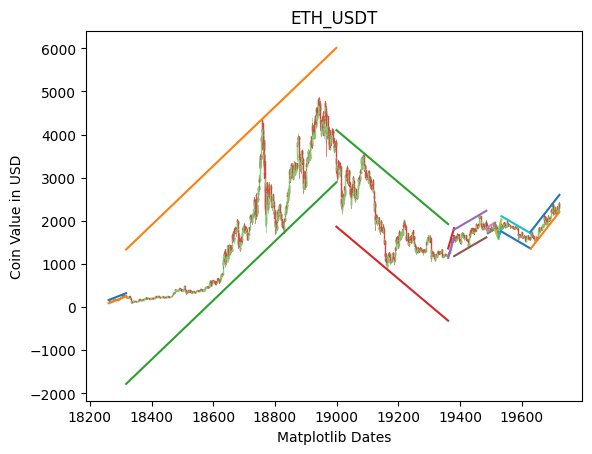

ETH:11
<12/31/2019, 00:00:00><02/25/2020, 12:00:00>
<02/25/2020, 16:00:00><01/06/2022, 20:00:00>
<01/07/2022, 00:00:00><01/04/2023, 00:00:00>
<01/04/2023, 04:00:00><01/23/2023, 08:00:00>
<01/23/2023, 12:00:00><05/07/2023, 20:00:00>
<05/08/2023, 00:00:00><05/12/2023, 16:00:00>
<05/12/2023, 20:00:00><06/05/2023, 00:00:00>
<06/05/2023, 04:00:00><06/16/2023, 12:00:00>
<06/16/2023, 16:00:00><06/25/2023, 12:00:00>
<06/25/2023, 16:00:00><09/28/2023, 08:00:00>
<09/28/2023, 12:00:00><12/30/2023, 16:00:00>


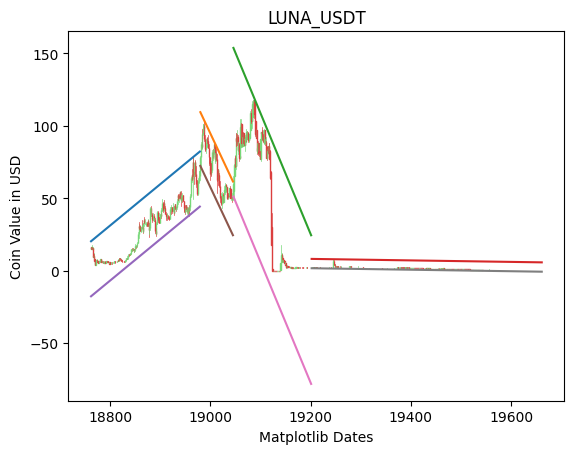

LUNA:4
<05/15/2021, 00:00:00><12/18/2021, 00:00:00>
<12/19/2021, 00:00:00><02/22/2022, 00:00:00>
<02/23/2022, 00:00:00><07/28/2022, 00:00:00>
<07/29/2022, 00:00:00><10/31/2023, 00:00:00>


In [ ]:
PLOT_DIR = Path("./Plots")

if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)

host = "https://api.gateio.ws"
prefix = "/api/v4"
headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}
endpoint = '/spot/candlesticks'
url = host + prefix + endpoint
max_API_request_allowed = 900

# Finding best fit regression lines
def lin_reg(data, threshold_channel_len):
    list_f = []
    X = []
    y = []
    for i in range(0,len(data)):
        X.append(data[i][0])
        avg = (data[i][2] + data[i][3])/2
        y.append(avg)
    X = np.array(X).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    l = 0
    j = threshold_channel_len
    while l<j and j <= len(data):
        score = []
        list_pf = []
        while j <= len(data):
            reg = LinearRegression().fit(X[l:j],y[l:j])
            temp_coeff = list(reg.coef_)
            temp_intercept = list(reg.intercept_)
            list_pf.append([temp_coeff[0][0], temp_intercept[0], l, j-1])
            score.append([reg.score(X[l:j],y[l:j]), j])
            j = j+1
        req_score = float("-inf")
        ind = -1
        temp_ind = -1
        # finding maximum score for identifying pivot points
        for i in range(len(score)):
            if(req_score<score[i][0]):
                ind = score[i][1]
                req_score = score[i][0]
                temp_ind = i
        list_f.append(list_pf[temp_ind])
        # for the next set of points
        l = ind
        j = ind + threshold_channel_len
    return list_f

def binary_search(data, line_type, m, b, epsilon):
    right = float("-inf")
    left = float("inf")
    get_y_intercept = lambda x, y: y - m*x
    for i in range(len(data)):
        d = data[i]
        curr_y = d[2] # high
        if(line_type=="bottom"):
            curr_y = d[3] # low
        curr = get_y_intercept(d[0], curr_y)
        right = max(right, curr)
        left = min(left, curr)

    sign = -1
    if(line_type=="bottom"):
        left, right = right, left
        sign = 1
    ans = right
    while(left<=right):
        mid = left + (right-left)//2
        # Calculating candlestick intersections
        intersection_count = 0
        for i in range(len(data)):
            d = data[i]
            curr_y = m*d[0]+mid
            candle_y = d[2]
            if(line_type=="bottom"):
                candle_y = d[3]
            if(line_type=="bottom" and (curr_y>candle_y and (curr_y-candle_y>epsilon))):
                intersection_count += 1
            if(line_type=="top" and (curr_y<candle_y and (candle_y-curr_y>epsilon))):
                intersection_count += 1
        if(intersection_count==0):
            right = mid + 1*sign
            ans = mid
        else:
            left = mid - 1*sign
    return ans

def plot_lines(lines, plt, converted_data):
    for m, b, start, end in lines:
        x_data = list(np.linspace(converted_data[start][0], converted_data[end][0], 10))
        y_data = [m*x + b for x in x_data]
        plt.xlabel("Matplotlib Dates")
        plt.ylabel("Coin Value in USD")
        plt.plot(x_data, y_data)

def get_API_data(currency, interval_timedelta, interval, start_datetime, end_datetime):
    curr_datetime = start_datetime
    total_dates = 0
    while(curr_datetime<=end_datetime):
        total_dates += 1
        curr_datetime += interval_timedelta
    data = []
    for i in range(0,total_dates,max_API_request_allowed):
        # Making API Get Request
        query_param = {
            "currency_pair": "{}_USDT".format(currency),
            "from": int((start_datetime+i*interval_timedelta).timestamp()),
            "to": int((start_datetime+(i+max_API_request_allowed-1)*interval_timedelta).timestamp()),
            "interval": interval,
        }
        r = requests.get(url=url, headers=headers, params=query_param)
        if(r.status_code!=200):
            print("Invalid API Request")
            return []
        data += r.json()
    return data

def testcasecase(currency, interval, startdate, enddate, threshold_channel_len, testcasecase_id):
    start_date_month, start_date_day, start_date_year = [int(x) for x in startdate.strip().split("/")]
    end_date_month, end_date_day, end_date_year = [int(x) for x in enddate.strip().split("/")]

    if(interval=="1h"):
        interval_timedelta = datetime.timedelta(hours=1)
    elif(interval=="4h"):
        interval_timedelta = datetime.timedelta(hours=4)
    elif(interval=="1d"):
        interval_timedelta = datetime.timedelta(days=1)
    else:
        # interval=="1w"
        interval_timedelta = datetime.timedelta(weeks=1)

    start_datetime = datetime.datetime(year=start_date_year, month=start_date_month, day=start_date_day)
    end_datetime = datetime.datetime(year=end_date_year, month=end_date_month, day=end_date_day)

    data = get_API_data(currency, interval_timedelta, interval, start_datetime, end_datetime)
    if(len(data)==0):
        return
    data = [[float(x) for x in d] for d in data]
    converted_data = []
    for d in data:
        converted_data.append([matplotlib.dates.date2num(datetime.datetime.utcfromtimestamp(d[0])), d[5], d[3], d[4], d[2]])

    # Creating Subplots
    fig, ax = plt.subplots()

    # Plotting Candlesticks
    candlestick_ohlc(ax, converted_data, width=0.4, colorup='#77d879', colordown='#db3f3f')

    # Getting fitting lines considering threshold channel length
    fitting_lines_data = lin_reg(converted_data, threshold_channel_len)
    top_fitting_lines_data = []
    bottom_fitting_lines_data = []
    epsilon = 0
    for i in range(len(fitting_lines_data)):
        m, b, start, end = fitting_lines_data[i]
        top_b = binary_search(converted_data[start:end+1], "top", m, b, epsilon)
        bottom_b = binary_search(converted_data[start:end+1], "bottom", m, b, epsilon)
        top_fitting_lines_data.append([m, top_b, start, end])
        bottom_fitting_lines_data.append([m, bottom_b, start, end])

    plot_lines(top_fitting_lines_data, plt, converted_data)
    plot_lines(bottom_fitting_lines_data, plt, converted_data)
    plt.title("{}_USDT".format(currency))
    file_name = "figure_{}_{}_USDT.png".format(testcasecase_id, currency)
    file_location = os.path.join(PLOT_DIR, file_name)
    plt.savefig(file_location)
    plt.show()

    date_ind_to_string = lambda ind: (start_datetime+ind*interval_timedelta).strftime("%m/%d/%Y, %H:%M:%S")
    # Printing Output
    print("{}:{}".format(currency, len(fitting_lines_data)))
    for i in range(len(fitting_lines_data)):
        _, _, start_ind, end_ind = fitting_lines_data[i]
        print("<{}><{}>".format(date_ind_to_string(start_ind), date_ind_to_string(end_ind)))

def main(filename):
    with open(filename, "r") as file:
        data = file.readlines()

    num_testcases = int(data[0].strip())
    threshold_channel_len = int(data[1].strip())
    for i in range(num_testcases):
        d = data[i+2].strip().split(",")
        d = [i.strip() for i in d]
        currency, interval, startdate, enddate = d
        testcasecase(currency, interval, startdate, enddate, threshold_channel_len, i+1)

if __name__ == "__main__":
    input_filename = "input.txt"
    main(input_filename)